In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from tqdm import tqdm

from ssd_model import SSD300, SSD512
from ssd_utils import PriorUtil
from ssd_metric import confusion_matrix, plot_confusion_matrix, accuracy, evaluate_results
from utils.model import load_weights

Using TensorFlow backend.


In [2]:
from data_voc import GTUtility
gt_util = GTUtility('./data/VOC2007test/')
#gt_util = GTUtility('./data/VOC2012test/')
weights_path = './models/ssd300_voc_weights_fixed.hdf5'; Model=SSD300
#weights_path = './models/ssd512_voc_weights_fixed.hdf5'; Model=SSD512

In [ ]:
from data_coco import GTUtility
gt_util = GTUtility('./data/COCO/', validation=True)
weights_path = './models/ssd300_voc_weights_fixed.hdf5'; Model=SSD300; gt_util = gt_util.convert_to_voc();
#weights_path = './models/ssd300_coco_weights_fixed.hdf5'; Model=SSD300

In [3]:
K.clear_session()
model = Model(num_classes=gt_util.num_classes)
prior_util = PriorUtil(model)
load_weights(model, weights_path)

batch_size = 32
num_batches = min(int(np.ceil((gt_util.num_samples)/batch_size)), 256)

data = []
preds = []

for i in tqdm(range(num_batches)):
    x, y = gt_util.sample_batch(batch_size, i, input_size=model.image_size)
    pred = model.predict(x, batch_size=batch_size, verbose=0)
    data.extend(y)
    preds.extend(pred)

100%|██████████| 155/155 [00:52<00:00,  1.83it/s]


### Grid search

In [4]:
steps = np.arange(0.05, 1, 0.05)

fmes_grid = np.zeros((len(steps)))

for i, t in enumerate(steps):
    results = [prior_util.decode(p, t) for p in preds]
    fmes = evaluate_results(data, results, gt_util, iou_thresh=0.5, max_dets=100, return_fmeasure=True)
    fmes_grid[i] = fmes
    print('threshold %.2f f-measure %.2f' % (t, fmes))

threshold 0.05 f-measure 0.35
threshold 0.10 f-measure 0.54
threshold 0.15 f-measure 0.60
threshold 0.20 f-measure 0.62
threshold 0.25 f-measure 0.63
threshold 0.30 f-measure 0.63
threshold 0.35 f-measure 0.63
threshold 0.40 f-measure 0.63
threshold 0.45 f-measure 0.62
threshold 0.50 f-measure 0.62
threshold 0.55 f-measure 0.61
threshold 0.60 f-measure 0.60
threshold 0.65 f-measure 0.59
threshold 0.70 f-measure 0.58
threshold 0.75 f-measure 0.57
threshold 0.80 f-measure 0.55
threshold 0.85 f-measure 0.52
threshold 0.90 f-measure 0.49
threshold 0.95 f-measure 0.43


0.3 0.6313846590221946


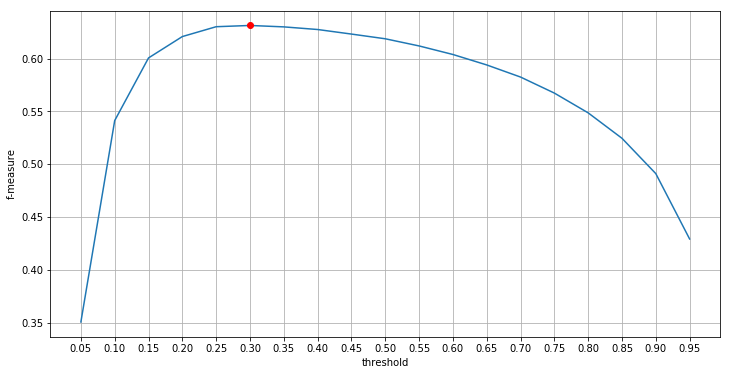

In [5]:
max_idx = np.argmax(fmes_grid)
print(steps[max_idx], fmes_grid[max_idx])
plt.figure(figsize=[12,6])
plt.plot(steps, fmes_grid)
plt.plot(steps[max_idx], fmes_grid[max_idx], 'or')
plt.xticks(steps)
plt.grid()
plt.xlabel('threshold')
plt.ylabel('f-measure')
plt.show()

In [4]:
confidence_threshold = 0.30 # voc model on voc 2007 test
#confidence_threshold = 0.70 # voc model on voc 2012 test
#confidence_threshold = 0.28 # voc model on coco test
#confidence_threshold = 0.25 # coco model on coco test

### Precision-recall curve, mean Average Precision

100%|██████████| 4952/4952 [00:12<00:00, 384.95it/s]


Class                     TP       FP       FN     AP
 1 Aeroplane             220     2761       91  0.665
 2 Bicycle               296     2561       93  0.708
 3 Bird                  385    32504      191  0.593
 4 Boat                  213    10632      180  0.444
 5 Bottle                354    39718      303  0.331
 6 Bus                   204     1671       50  0.759
 7 Car                  1007    22690      534  0.604
 8 Cat                   347     1536       23  0.905
 9 Chair                 838    52522      536  0.433
10 Cow                   227     2247      102  0.625
11 Diningtable           243     6524       56  0.662
12 Dog                   477     2331       53  0.845
13 Horse                 325     1211       70  0.796
14 Motorbike             286      923       83  0.742
15 Person               3628   104716     3111  0.486
16 Pottedplant           343    20699      249  0.410
17 Sheep                 190     6865      121  0.544
18 Sofa                  359

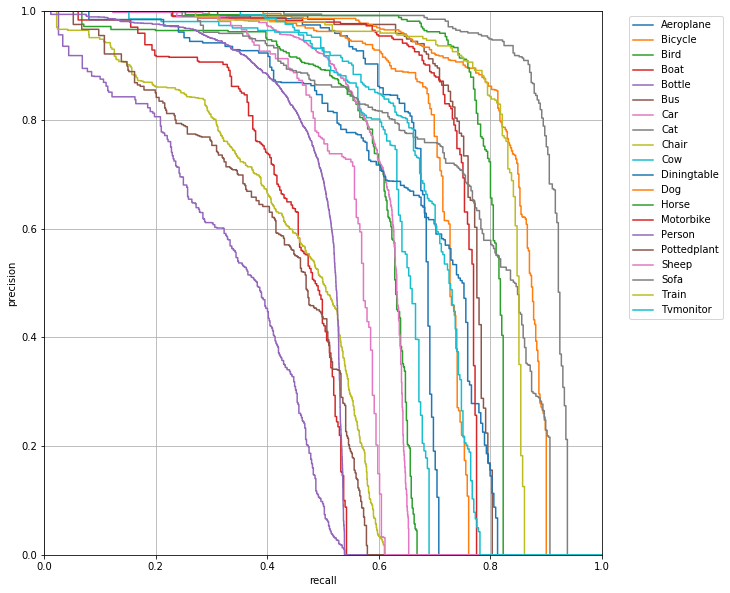

In [6]:
results = [prior_util.decode(p, confidence_threshold=0.01, keep_top_k=400) for p in tqdm(preds)]
evaluate_results(data, results, gt_util, iou_thresh=0.5, max_dets=100)

### Confusion matrix of local predictions

100%|██████████| 4952/4952 [00:36<00:00, 136.39it/s]


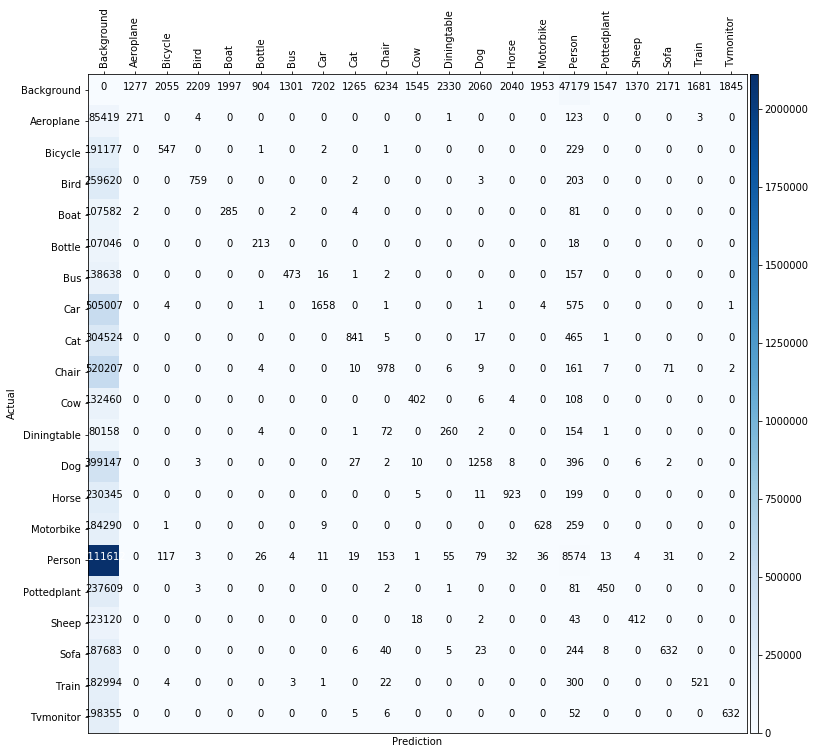

0.0032356055612995523

In [8]:
results = [prior_util.decode(p, confidence_threshold) for p in tqdm(preds)]
encoded_gt = [prior_util.encode(d) for d in tqdm(data)]

y_true_all = []
y_pred_all = []

for i in range(len(data)):
    y_true = np.argmax(encoded_gt[i][:,4:], axis=1)
    y_pred = np.argmax(preds[i][:,4:], axis=1)
    #prior_object_idx = np.where(y_true)[0] # gt prior box contains object
    prior_object_idx = np.where(y_true+y_pred)[0] # gt or prediction prior box contains object
    y_true_all.extend(y_true[prior_object_idx])
    y_pred_all.extend(y_pred[prior_object_idx])

cm = confusion_matrix(y_true_all, y_pred_all, gt_util.num_classes)
plot_confusion_matrix(cm, gt_util.classes, figsize=[12]*2)
accuracy(y_true_all, y_pred_all)